In [1]:
from torch.autograd import Variable
from torch.utils import data
from typing import Any, Dict, List
import collections
import json
import numpy as np
import os
import pandas as pd
import pickle
import string
import tensorboardX
import torch

In [2]:
import matplotlib.pyplot as plt

In [3]:
def load_data(file_path) -> pd.DataFrame:
    with open(file_path, 'r') as infile:
        data = infile.read().split('\n')

    data = list(map(json.loads, data[:-1]))

    df = pd.DataFrame(data)
    
    print(len(df))
    df = df.loc[df.gold_label != '-']
    print(len(df))
    return df

In [4]:
file_path_train = 'data/multinli_1.0_train.jsonl'
file_path_val = 'data/multinli_1.0_dev_matched.jsonl'

In [5]:
%%time
df_train = load_data(file_path_train)

392702
392702
CPU times: user 6.61 s, sys: 1.22 s, total: 7.83 s
Wall time: 7.83 s


In [6]:
%%time
df_val = load_data(file_path_val)

10000
9815
CPU times: user 257 ms, sys: 8.5 ms, total: 266 ms
Wall time: 262 ms


In [7]:
df_train.head()

,annotator_labels,genre,gold_label,pairID,promptID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
0,[neutral],government,neutral,31193n,31193,Conceptually cream skimming has two basic dime...,( ( Conceptually ( cream skimming ) ) ( ( has ...,(ROOT (S (NP (JJ Conceptually) (NN cream) (NN ...,Product and geography are what make cream skim...,( ( ( Product and ) geography ) ( ( are ( what...,(ROOT (S (NP (NN Product) (CC and) (NN geograp...
1,[entailment],telephone,entailment,101457e,101457,you know during the season and i guess at at y...,( you ( ( know ( during ( ( ( the season ) and...,(ROOT (S (NP (PRP you)) (VP (VBP know) (PP (IN...,You lose the things to the following level if ...,( You ( ( ( ( lose ( the things ) ) ( to ( the...,(ROOT (S (NP (PRP You)) (VP (VBP lose) (NP (DT...
2,[entailment],fiction,entailment,134793e,134793,One of our number will carry out your instruct...,( ( One ( of ( our number ) ) ) ( ( will ( ( (...,(ROOT (S (NP (NP (CD One)) (PP (IN of) (NP (PR...,A member of my team will execute your orders w...,( ( ( A member ) ( of ( my team ) ) ) ( ( will...,(ROOT (S (NP (NP (DT A) (NN member)) (PP (IN o...
3,[entailment],fiction,entailment,37397e,37397,How do you know? All this is their information...,( ( How ( ( ( do you ) know ) ? ) ) ( ( All th...,(ROOT (S (SBARQ (WHADVP (WRB How)) (SQ (VBP do...,This information belongs to them.,( ( This information ) ( ( belongs ( to them )...,(ROOT (S (NP (DT This) (NN information)) (VP (...
4,[neutral],telephone,neutral,50563n,50563,yeah i tell you what though if you go price so...,( yeah ( i ( ( tell you ) ( what ( ( though ( ...,(ROOT (S (VP (VB yeah) (S (NP (FW i)) (VP (VB ...,The tennis shoes have a range of prices.,( ( The ( tennis shoes ) ) ( ( have ( ( a rang...,(ROOT (S (NP (DT The) (NN tennis) (NNS shoes))...


In [8]:
df_val.head()

,annotator_labels,genre,gold_label,pairID,promptID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
0,"[neutral, entailment, neutral, neutral, neutral]",slate,neutral,63735n,63735,The new rights are nice enough,( ( The ( new rights ) ) ( are ( nice enough )...,(ROOT (S (NP (DT The) (JJ new) (NNS rights)) (...,Everyone really likes the newest benefits,( Everyone ( really ( likes ( the ( newest ben...,(ROOT (S (NP (NN Everyone)) (VP (ADVP (RB real...
1,"[contradiction, contradiction, contradiction, ...",government,contradiction,91383c,91383,This site includes a list of all award winners...,( ( This site ) ( ( includes ( ( ( ( a list ) ...,(ROOT (S (NP (DT This) (NN site)) (VP (VBZ inc...,The Government Executive articles housed on th...,( ( ( The ( Government ( Executive articles ) ...,(ROOT (S (NP (NP (DT The) (NNP Government) (NN...
2,"[entailment, entailment, entailment, entailmen...",telephone,entailment,755e,755,uh i don't know i i have mixed emotions about ...,( ( ( ( uh ( i ( ( do n't ) ( know ( ( i i ) (...,(ROOT (SINV (S (S (INTJ (UH uh)) (NP (FW i)) (...,"I like him for the most part, but would still ...",( I ( ( ( ( ( ( like him ) ( for ( the ( most ...,(ROOT (S (NP (PRP I)) (VP (VP (VBP like) (NP (...
3,"[contradiction, contradiction, contradiction, ...",telephone,contradiction,78013c,78013,yeah i i think my favorite restaurant is alway...,( yeah ( ( i i ) ( think ( ( my ( favorite res...,(ROOT (S (VP (VB yeah) (NP (NP (FW i) (FW i)) ...,My favorite restaurants are always at least a ...,( ( My ( favorite restaurants ) ) ( ( ( ( are ...,(ROOT (S (NP (PRP$ My) (JJ favorite) (NNS rest...
4,"[contradiction, contradiction, contradiction, ...",telephone,contradiction,96377c,96377,i don't know um do you do a lot of camping,( i ( ( do n't ) ( know ( um ( do ( you ( do (...,(ROOT (S (NP (FW i)) (VP (VBP do) (RB n't) (VP...,I know exactly.,( I ( ( know exactly ) . ) ),(ROOT (S (NP (PRP I)) (VP (VBP know) (ADVP (RB...


In [9]:
df_train.head(10)[['sentence1', 'sentence2', 'gold_label']]

,sentence1,sentence2,gold_label
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,neutral
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,entailment
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,entailment
3,How do you know? All this is their information...,This information belongs to them.,entailment
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,neutral
5,my walkman broke so i'm upset now i just have ...,I'm upset that my walkman broke and now I have...,entailment
6,But a few Christian mosaics survive above the ...,Most of the Christian mosaics were destroyed b...,neutral
7,(Read for Slate 's take on Jackson's findings.),Slate had an opinion on Jackson's findings.,entailment
8,Gays and lesbians.,Heterosexuals.,contradiction
9,At the end of Rue des Francs-Bourgeois is what...,Place des Vosges is constructed entirely of gr...,contradiction


(array([207.,  16.,  13.,   8.,   7.,   9.,   7.,   8.,  12.,  14.]),
 array([1.0000e+00, 7.4250e+02, 1.4840e+03, 2.2255e+03, 2.9670e+03,
        3.7085e+03, 4.4500e+03, 5.1915e+03, 5.9330e+03, 6.6745e+03,
        7.4160e+03]),
 <a list of 10 Patch objects>)

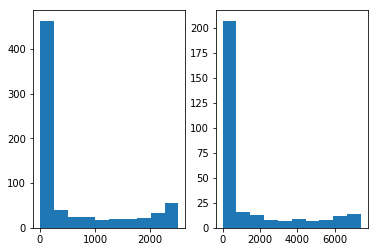

In [10]:
plt.subplot(1, 2, 1)
plt.hist(df_train.sentence1.apply(len).value_counts())

plt.subplot(1, 2, 2)
plt.hist(df_train.sentence2.apply(len).value_counts())

# Data loader

In [11]:
def load_word_vectors(file_path: str) -> Dict:
    with open(file_path, 'r') as infile:
        data_glove = infile.read().split('\n')

    data_glove = map(lambda x: x.split(), data_glove)  # Split the words

    glove = {
        line[0]: np.array(line[1:], dtype=np.float32)
        for line in data_glove
        if len(line) == 301
    }

    return glove


class MNLIDataset(data.Dataset):
    def __init__(self, df: pd.DataFrame, word_vectors: Dict) -> None:
        df['label_id'] = df.gold_label.map(lbl_to_id)
        df['sentence1'] = df['sentence1'].apply(lambda x: x.strip(string.punctuation))
        df['sentence2'] = df['sentence2'].apply(lambda x: x.strip(string.punctuation))

        self.df = df
        self.word_vectors = word_vectors
        
    def __len__(self) -> int:
        return len(self.df)

    def _sentence_to_vec(self, sentence: str) -> np.ndarray:
        # FIXME
        vectors = []
        final_sentence = []
        for word in sentence.split(' '):
            if word not in self.word_vectors:
                vectors.append(np.zeros(300, dtype=np.float32))
                continue

            final_sentence.append(word)
            vectors.append(self.word_vectors[word])

#         vectors = np.vstack(vectors)
        vectors = np.array(vectors)
        final_sentence = ' '.join(final_sentence)
        return vectors, final_sentence
        
    def _preprocess(self, record):
        # Convert sentences to word vectors, return list of 
        v1, fs1 = self._sentence_to_vec(record['sentence1'])
        v2, fs2 = self._sentence_to_vec(record['sentence2'])
        return {
            'sentence1': v1,
            'sentence2': v2,
            'label': record['label_id'],
            'final_sentence1': fs1,
            'final_sentence2': fs2,
        }

    def __getitem__(self, ix):
        return self._preprocess(self.df.iloc[ix])

In [12]:
id_to_lbl = ['neutral', 'entailment', 'contradiction']
lbl_to_id = {
    lbl: ix
    for ix, lbl in enumerate(id_to_lbl)
}

In [13]:
%%time
pickle_file = 'models/glove.pickle'
if not os.path.exists(pickle_file):
    glove = load_word_vectors('models/glove.840B.300d.txt')  # FIXME: There shold be 2196017 words
    print(len(glove))

    with open(pickle_file, 'wb') as outfile:
        pickle.dump(glove, outfile)

CPU times: user 39 µs, sys: 17 µs, total: 56 µs
Wall time: 49.8 µs


In [14]:
%%time
with open(pickle_file, 'rb') as infile:
    glove = pickle.load(infile)

CPU times: user 6.48 s, sys: 2.9 s, total: 9.38 s
Wall time: 9.28 s


### Get the dataloader!

In [15]:
BATCH_SIZE = 1

In [16]:
dataset_train = MNLIDataset(df_train, word_vectors=glove)
dataloader_train = data.DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)

In [17]:
dataset_val = MNLIDataset(df_val, word_vectors=glove)
dataloader_val = data.DataLoader(dataset=dataset_val, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)

In [18]:
print(len(dataset_train), len(dataloader_train))
print(len(dataset_val), len(dataloader_val))

392702 392702
9815 9815


### Class Weights

In [19]:
# We have balanced classes
df_train.gold_label.value_counts()

contradiction    130903
neutral          130900
entailment       130899
Name: gold_label, dtype: int64

In [20]:
# We have balanced classes
df_val.gold_label.value_counts()

entailment       3479
contradiction    3213
neutral          3123
Name: gold_label, dtype: int64

## Basic network

In [21]:
import torch.nn.functional as F

In [22]:
class CBOW(torch.nn.Module):
    def __init__(self, vector_dim=300, n_out=3) -> None:
        super().__init__()
        in_size = vector_dim * 4
        
        self.feature_extractor = torch.nn.Sequential(
            torch.nn.Linear(in_size, 1024),
            torch.nn.Tanh(),
            torch.nn.Linear(1024, 1024),
            torch.nn.Tanh(),
            torch.nn.Linear(1024, 1024),
            torch.nn.Tanh(),
        )
        self.classifier = torch.nn.Linear(1024, n_out)
        self.vector_dim = vector_dim

    def forward(self, data):
        vectors1, vectors2 = data
#         print(vectors1.shape, vectors2.shape)
        s1, s2 = torch.sum(vectors1, dim=1), torch.sum(vectors2, dim=1)
#         print(s1.shape, s2.shape)
        
        features = torch.cat([s1, s2, s1-s2, s1*s2], dim=1)
        features = self.feature_extractor(features)
#         print(features.shape)
        pred = self.classifier(features)
        return F.log_softmax(pred, dim=1)

In [54]:
class LSTM(torch.nn.Module):
    def __init__(self, vector_dim=300, proj_dim=300, num_layers=1) -> None:
        super().__init__()
        
        self.projection = torch.nn.Linear(vector_dim, proj_dim)
        self.lstm = torch.nn.LSTM(proj_dim, proj_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(proj_dim * num_layers * 2 * 4, 2048),
            torch.nn.Linear(2048, 2048),
            torch.nn.Linear(2048, 3),
        )
    
    def _sentence_features(self, vectors):
        proj = self.projection(vectors)
        _, (hT, _) = self.lstm(vectors)

        sentence_vec = hT.transpose(0, 1)  # get batch first: B*num_layers*num_directions*300
        sentence_vec = sentence_vec.contiguous().view(sentence_vec.shape[0], -1)
        return sentence_vec

    def forward(self, data):
        vectors1, vectors2 = data

        sentence_vec1 = self._sentence_features(vectors1)
        sentence_vec2 = self._sentence_features(vectors2)
        
        features = torch.cat([sentence_vec1, sentence_vec1, sentence_vec1 - sentence_vec2, sentence_vec1 * sentence_vec2],
                             dim=1)
        pred = self.classifier(features)
        return F.log_softmax(pred, dim=1)

In [55]:
def test_lstm():
    bsz = 3
    seq1 = torch.from_numpy(np.random.rand(bsz, 20, 300,).astype(np.float32))
    seq2 = torch.from_numpy(np.random.rand(bsz, 24, 300,).astype(np.float32))

    model = LSTM()

    outputs = model((seq1, seq2))
    assert outputs.shape == (bsz, 3)

test_lstm()

## Train

In [56]:
def prep_inputs(batch, device=0):
    inputs = (Variable(batch['sentence1']).cuda(device=DEVICE),
              Variable(batch['sentence2']).cuda(device=DEVICE))
    label = Variable(batch['label']).cuda(device=DEVICE)

    return inputs, label

def evaluate(model, dataloader, loss_func, device, n_batches=10):
    loss = 0
    accuracy = 0
    model.train(False)

    for ix, batch in enumerate(dataloader):
        if ix >= n_batches:
            break
        
        inputs, label = prep_inputs(batch)
        
        predicted = model(inputs)

        loss += loss_func(predicted, label)
        prediction = torch.argmax(predicted, dim=1)

        # TODO: get the confusion here
        accuracy += (torch.sum(prediction == label).data.cpu().numpy() / len(prediction))

    accuracy /= n_batches
    loss /= n_batches
    
    model.train(True)
    
    return loss, accuracy

In [57]:
n_epochs = 8
val_every = 1000

DEVICE=1

In [82]:
# model = CBOW().cuda(device=DEVICE)
model = LSTM().cuda(device=DEVICE)

loss_func = torch.nn.NLLLoss().cuda(device=DEVICE)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [83]:
model_str = 'lstm-1.3'
model_dir = 'models/{}'.format(model_str)
log_dir = 'logs/{}'.format(model_str)

os.makedirs(model_dir)
writer = tensorboardX.SummaryWriter(log_dir)

In [84]:
epoch = 0

In [85]:
n_params = 0
for param in model.parameters():
    if param.requires_grad: n_params += np.prod(param.size())

print(n_params)

10654847


In [86]:
params_init = [p.clone() for p in list(model.parameters())]

In [87]:
def compare_params(params1, params2):
    for ix, (param1, param2) in enumerate(zip(params1[::-1], params2[::-1])):
        assert not np.all((param1 - param2).data.cpu().numpy() == 0)

In [88]:
while epoch < n_epochs:
    model.train(True)
    
    for iteration, batch in enumerate(dataloader_train):
        inputs, label = prep_inputs(batch)

        predicted = model(inputs)

        optimizer.zero_grad()
        loss_train = loss_func(predicted, label)
        loss_train.backward()
        optimizer.step()

        
        # Log to tensorboard
        iter_total = (epoch * len(dataloader_train)) + iteration
        writer.add_scalar('train.loss', loss_train.data.cpu().numpy(), iter_total)

        # Calculate validation accuracy
        if iteration > 0 and iteration % val_every == 0:
#             compare_params(params_init, list(model.parameters()))
            loss_val, acc_val = evaluate(model, dataloader_val, device=DEVICE, loss_func=loss_func, n_batches=200)

            s = "Epoch: {}, {:.2f}%: train loss: {}, validation loss: {}, validation acc: {}".format(
                epoch, (iteration / len(dataloader_train)) * 100, loss_train.data.cpu().numpy(), loss_val, acc_val
            )
            print(s)
            writer.add_scalar('val.loss', loss_val, iter_total)
            writer.add_scalar('val.acc', acc_val, iter_total)

    print('\n------------------------------------------------------------------------------------------------------------')
    print("Epoch:", epoch + 1, "label accuracy:", acc_val)
    print('------------------------------------------------------------------------------------------------------------\n')

    torch.save(model.state_dict(), f=os.path.join(model_dir, '{}_{}_{}.pt'.format(model_str, epoch, iteration)))
    epoch += 1

Epoch: 0, 0.25%: train loss: 0.9429846405982971, validation loss: 1.1070126295089722, validation acc: 0.315
Epoch: 0, 0.51%: train loss: 1.0366706848144531, validation loss: 1.0879102945327759, validation acc: 0.365
Epoch: 0, 0.76%: train loss: 1.1959459781646729, validation loss: 1.0961562395095825, validation acc: 0.38
Epoch: 0, 1.02%: train loss: 0.9823434948921204, validation loss: 1.104907512664795, validation acc: 0.32
Epoch: 0, 1.27%: train loss: 1.0809249877929688, validation loss: 1.0903748273849487, validation acc: 0.37
Epoch: 0, 1.53%: train loss: 1.0018305778503418, validation loss: 1.066785454750061, validation acc: 0.4
Epoch: 0, 1.78%: train loss: 1.262559413909912, validation loss: 1.0909974575042725, validation acc: 0.38
Epoch: 0, 2.04%: train loss: 1.2582809925079346, validation loss: 1.0709049701690674, validation acc: 0.395
Epoch: 0, 2.29%: train loss: 0.8611787557601929, validation loss: 1.0536106824874878, validation acc: 0.435
Epoch: 0, 2.55%: train loss: 1.245599

Epoch: 0, 19.86%: train loss: 1.3661848306655884, validation loss: 0.9893593192100525, validation acc: 0.515
Epoch: 0, 20.12%: train loss: 1.4266242980957031, validation loss: 0.9912987947463989, validation acc: 0.52
Epoch: 0, 20.37%: train loss: 0.37091517448425293, validation loss: 1.0075480937957764, validation acc: 0.51
Epoch: 0, 20.63%: train loss: 1.3552892208099365, validation loss: 0.9607691764831543, validation acc: 0.555
Epoch: 0, 20.88%: train loss: 0.7122458815574646, validation loss: 1.0491447448730469, validation acc: 0.455
Epoch: 0, 21.14%: train loss: 0.6092854738235474, validation loss: 0.988633930683136, validation acc: 0.52
Epoch: 0, 23.17%: train loss: 1.4049009084701538, validation loss: 0.9959254860877991, validation acc: 0.53
Epoch: 0, 23.43%: train loss: 1.9361369609832764, validation loss: 0.9954379200935364, validation acc: 0.52
Epoch: 0, 23.68%: train loss: 1.049988865852356, validation loss: 0.9735998511314392, validation acc: 0.52
Epoch: 0, 23.94%: train lo

Epoch: 0, 41.00%: train loss: 1.2633863687515259, validation loss: 0.9303086400032043, validation acc: 0.545
Epoch: 0, 41.25%: train loss: 1.5489689111709595, validation loss: 0.9397305250167847, validation acc: 0.565
Epoch: 0, 41.51%: train loss: 0.618009090423584, validation loss: 0.9751001000404358, validation acc: 0.57
Epoch: 0, 41.76%: train loss: 0.2170577049255371, validation loss: 0.986003041267395, validation acc: 0.54
Epoch: 0, 42.02%: train loss: 0.725407600402832, validation loss: 0.9795070290565491, validation acc: 0.555
Epoch: 0, 42.27%: train loss: 1.3753286600112915, validation loss: 0.9913241267204285, validation acc: 0.5
Epoch: 0, 42.53%: train loss: 0.9794507026672363, validation loss: 0.9792866110801697, validation acc: 0.505
Epoch: 0, 42.78%: train loss: 0.7217432260513306, validation loss: 0.939351499080658, validation acc: 0.54
Epoch: 0, 43.04%: train loss: 0.11345362663269043, validation loss: 0.9538116455078125, validation acc: 0.53
Epoch: 0, 43.29%: train loss

Epoch: 0, 60.35%: train loss: 1.5986382961273193, validation loss: 0.9410046339035034, validation acc: 0.58
Epoch: 0, 60.61%: train loss: 0.9610207080841064, validation loss: 0.9539223313331604, validation acc: 0.53
Epoch: 0, 60.86%: train loss: 0.7043774724006653, validation loss: 0.931893527507782, validation acc: 0.57
Epoch: 0, 61.12%: train loss: 0.8820306658744812, validation loss: 0.961658775806427, validation acc: 0.535
Epoch: 0, 61.37%: train loss: 0.30208420753479004, validation loss: 0.9589882493019104, validation acc: 0.525
Epoch: 0, 61.62%: train loss: 0.8126301169395447, validation loss: 0.9256336092948914, validation acc: 0.6
Epoch: 0, 61.88%: train loss: 0.5087535977363586, validation loss: 0.915726363658905, validation acc: 0.53
Epoch: 0, 62.13%: train loss: 1.0642166137695312, validation loss: 0.9307279586791992, validation acc: 0.56
Epoch: 0, 62.39%: train loss: 0.6449586749076843, validation loss: 0.9802358150482178, validation acc: 0.505
Epoch: 0, 62.64%: train loss

KeyboardInterrupt: 

## Test

In [ ]:
plt.subplot(1, 2, 1)
plt.hist(df_train.sentence1.apply(len).value_counts())

plt.subplot(1, 2, 2)
plt.hist(df_train.sentence2.apply(len).value_counts())